In [35]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint

In [36]:
torch.__version__

'2.2.1+cu121'

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
# Initialize empty lists to store dialogues
dialogues = []

# Read the text file line by line
with open('shakespeare.txt', 'r') as file:
    current_dialogue = ""
    for line in file:
        line = line.strip()  # Remove leading/trailing whitespace
        if line:  # Check if the line is not empty
            current_dialogue += line + " "
        else:
            # If line is empty, it indicates the end of a dialogue
            if current_dialogue:
                dialogues.append(current_dialogue.strip())  # Add the dialogue to the list
                current_dialogue = ""  # Reset current dialogue

# If there's a remaining dialogue after reading all lines
if current_dialogue:
    dialogues.append(current_dialogue.strip())

# Create a pandas DataFrame
df = pd.DataFrame({'Dialogue': dialogues})



In [41]:
words = df["Dialogue"]
words = words.str.lower()
words = words.str.strip()
words = words.head(100)
# words = words.str.replace(" ", "")

# words = words[words.str.len() > 2]
# words = words[words.str.len() < 10]

# Randomly shuffle the words
words = words.sample(frac=1).reset_index(drop=True)
words = words.tolist()

# Remove words having non alphabets
# words = [word for word in words if word.isalpha()]

words[:10]

["messenger: where's caius marcius?",
 'cominius: you have fought together.',
 'aufidius: and keep your honours safe!',
 "menenius: i tell you, friends, most charitable care have the patricians of you. for your wants, your suffering in this dearth, you may as well strike at the heaven with your staves as lift them against the roman state, whose course will on the way it takes, cracking ten thousand curbs of more strong link asunder than can ever appear in your impediment. for the dearth, the gods, not the patricians, make it, and your knees to them, not arms, must help. alack, you are transported by calamity thither where more attends you, and you slander the helms o' the state, who care for you like fathers, when you curse them as enemies.",
 "first citizen: well, i'll hear it, sir: yet you must not think to fob off our disgrace with a tale: but, an 't please you, deliver.",
 "brutus: fame, at the which he aims, in whom already he's well graced, can not better be held nor more attain'

In [42]:
len(words)

100

In [43]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i for i,s in enumerate(chars)}
# stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
pprint(itos)

{0: ' ',
 1: '!',
 2: "'",
 3: ',',
 4: '-',
 5: '.',
 6: ':',
 7: ';',
 8: '?',
 9: 'a',
 10: 'b',
 11: 'c',
 12: 'd',
 13: 'e',
 14: 'f',
 15: 'g',
 16: 'h',
 17: 'i',
 18: 'j',
 19: 'k',
 20: 'l',
 21: 'm',
 22: 'n',
 23: 'o',
 24: 'p',
 25: 'q',
 26: 'r',
 27: 's',
 28: 't',
 29: 'u',
 30: 'v',
 31: 'w',
 32: 'x',
 33: 'y',
 34: 'z'}


In [88]:
block_size = 8 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:]:

  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

# Move data to GPU

print(len(X), len(Y))
X = torch.tensor(X[:10000]).to(device)
Y = torch.tensor(Y[:10000]).to(device)

Streaming output truncated to the last 5000 lines.
orthy ma ---> r
rthy mar ---> c
thy marc ---> i
hy marci ---> u
y marciu ---> s
 marcius ---> ,
marcius, --->  
arcius,  ---> a
rcius, a ---> t
cius, at ---> t
ius, att ---> e
us, atte ---> n
s, atten ---> d
, attend --->  
 attend  ---> u
attend u ---> p
ttend up ---> o
tend upo ---> n
end upon --->  
nd upon  ---> c
d upon c ---> o
 upon co ---> m
upon com ---> i
pon comi ---> n
on comin ---> i
n comini ---> u
 cominiu ---> s
cominius --->  
ominius  ---> t
minius t ---> o
inius to --->  
nius to  ---> t
ius to t ---> h
us to th ---> e
s to the ---> s
 to thes ---> e
to these --->  
o these  ---> w
 these w ---> a
these wa ---> r
hese war ---> s
ese wars ---> .
se wars. ---> .
         ---> m
       m ---> e
      me ---> n
     men ---> e
    mene ---> n
   menen ---> i
  meneni ---> u
 meneniu ---> s
menenius ---> :
enenius: --->  
nenius:  ---> o
enius: o ---> ,
nius: o, --->  
ius: o,  ---> t
us: o, t ---> r
s: o, tr ---> u
: o, 

In [90]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([10000, 8]), torch.int64, torch.Size([10000]), torch.int64)

In [89]:
# Embedding layer for the context

emb_dim = 5
emb = torch.nn.Embedding(len(stoi), emb_dim)
emb.to(device)


Embedding(35, 5)

In [91]:
emb.weight

Parameter containing:
tensor([[-0.7276, -2.3278, -2.0257, -1.7759, -0.3509],
        [-0.6444,  1.8373, -0.9246, -0.8554, -1.5053],
        [ 0.9337, -0.6522, -0.1269, -0.2407, -0.3654],
        [-1.2833, -1.2678, -0.5354, -1.9021,  0.4936],
        [-0.5178,  0.2238,  2.0543, -1.5648, -0.9066],
        [-0.7077,  0.4198,  0.1719,  0.8594, -0.8280],
        [ 1.7013,  1.3081,  0.1815,  0.6745, -0.7241],
        [-1.3576, -0.8545, -0.4035, -0.8065,  2.2213],
        [-0.8324, -0.3060,  0.4140, -0.8727,  0.0398],
        [ 1.0311,  0.6424,  0.6020, -0.6543,  1.2983],
        [ 1.1083,  1.1130, -0.1588,  1.7098,  0.8266],
        [ 0.2394,  0.7678, -0.2904,  0.3947, -0.7828],
        [-0.7959, -1.2068, -0.6636,  0.8878,  0.1917],
        [-0.3073, -0.1435,  0.1033,  0.7343,  0.2954],
        [-2.4779, -1.5479,  0.4490, -0.2627, -1.3724],
        [ 0.3788,  1.2571, -1.1604,  1.8972,  0.0460],
        [ 0.3659,  0.0851,  0.7494,  0.0719,  1.2836],
        [-0.7024,  0.0124,  1.6648,  0.9324

In [83]:
emb.weight.shape

torch.Size([35, 5])

<Axes: >

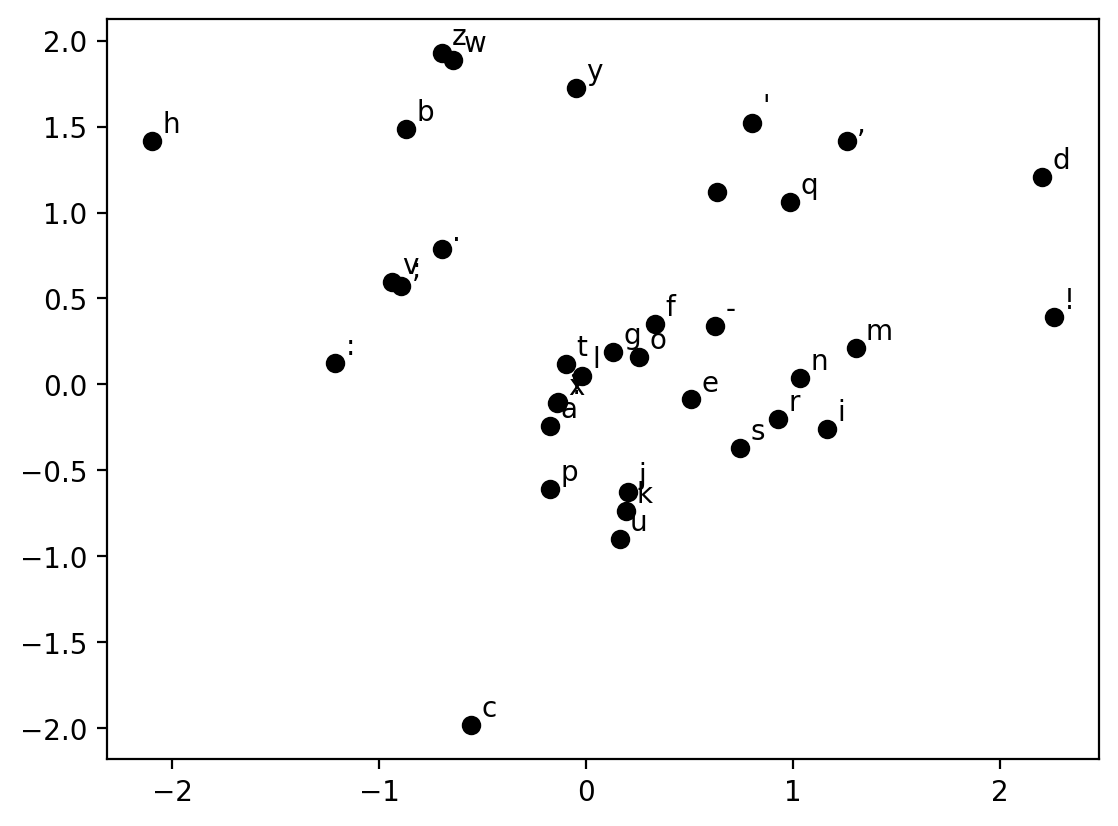

In [58]:
# Function to visualize the embedding in 2d space

def plot_emb(emb, itos, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    for i in range(len(itos)):
        # print(itos)
        x, y = emb.weight[i].detach().cpu().numpy()
        ax.scatter(x, y, color='k')
        ax.text(x + 0.05, y + 0.05, itos[i])
    return ax

plot_emb(emb, itos)

In [109]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NextChar(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)

        # Increase the depth of the network
        self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)  # Batch normalization
        self.dropout1 = nn.Dropout(p=0.5)       # Dropout

        self.lin2 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn2 = nn.BatchNorm1d(hidden_size // 2)  # Batch normalization
        self.dropout2 = nn.Dropout(p=0.5)            # Dropout

        self.lin3 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.bn3 = nn.BatchNorm1d(hidden_size // 4)  # Batch normalization
        self.dropout3 = nn.Dropout(p=0.5)            # Dropout

        self.lin4 = nn.Linear(hidden_size // 4, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)

        x = F.sin(self.lin1(x))
        x = self.bn1(x)
        x = self.dropout1(x)

        x = F.relu(self.lin2(x))
        x = self.bn2(x)
        x = self.dropout2(x)

        x = F.relu(self.lin3(x))
        x = self.bn3(x)
        x = self.dropout3(x)

        x = self.lin4(x)
        return x


In [110]:
# Generate names from untrained model


model = NextChar(block_size, len(stoi), emb_dim, 100).to(device)
model = torch.compile(model)

g = torch.Generator()
g.manual_seed(4000002)
def generate_name(model, itos, stoi, block_size, max_len=10):
    context = [0] * block_size
    name = ''
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        ch = itos[ix]
        if ch == '.':
            break
        name += ch
        context = context[1:] + [ix]
    return name

for i in range(10):
    print(generate_name(model, itos, stoi, block_size))

[2024-03-20 14:42:09,103] torch._dynamo.convert_frame: [WARNING] WON'T CONVERT forward <ipython-input-109-f4290244c94b> line 25 
[2024-03-20 14:42:09,103] torch._dynamo.convert_frame: [WARNING] due to: 
[2024-03-20 14:42:09,103] torch._dynamo.convert_frame: [WARNING] Traceback (most recent call last):
[2024-03-20 14:42:09,103] torch._dynamo.convert_frame: [WARNING]   File "/usr/local/lib/python3.10/dist-packages/torch/_dynamo/convert_frame.py", line 727, in _convert_frame
[2024-03-20 14:42:09,103] torch._dynamo.convert_frame: [WARNING]     result = inner_convert(frame, cache_entry, hooks, frame_state)
[2024-03-20 14:42:09,103] torch._dynamo.convert_frame: [WARNING]   File "/usr/local/lib/python3.10/dist-packages/torch/_dynamo/convert_frame.py", line 383, in _convert_frame_assert
[2024-03-20 14:42:09,103] torch._dynamo.convert_frame: [WARNING]     compiled_product = _compile(
[2024-03-20 14:42:09,103] torch._dynamo.convert_frame: [WARNING]   File "/usr/local/lib/python3.10/dist-packages

AttributeError: module 'torch.nn.functional' has no attribute 'sin'

In [97]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

_orig_mod.emb.weight torch.Size([35, 5])
_orig_mod.lin1.weight torch.Size([30, 40])
_orig_mod.lin1.bias torch.Size([30])
_orig_mod.lin2.weight torch.Size([15, 30])
_orig_mod.lin2.bias torch.Size([15])
_orig_mod.lin3.weight torch.Size([35, 15])
_orig_mod.lin3.bias torch.Size([35])


In [105]:
# Train the model

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.01)
import time
# Mini-batch training
batch_size = 100
print_every = 10
elapsed_time = []
for epoch in range(1000):
    start_time = time.time()
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    if epoch % print_every == 0:
        print(epoch, loss.item())


0 2.131716251373291
10 1.0464897155761719
20 0.9225502014160156
30 0.7922714352607727
40 0.7714866399765015
50 0.6887481808662415
60 0.5997711420059204
70 0.6423113942146301
80 0.6622154712677002
90 0.696241021156311
100 0.7689342498779297
110 0.6072829365730286


KeyboardInterrupt: 

<Axes: >

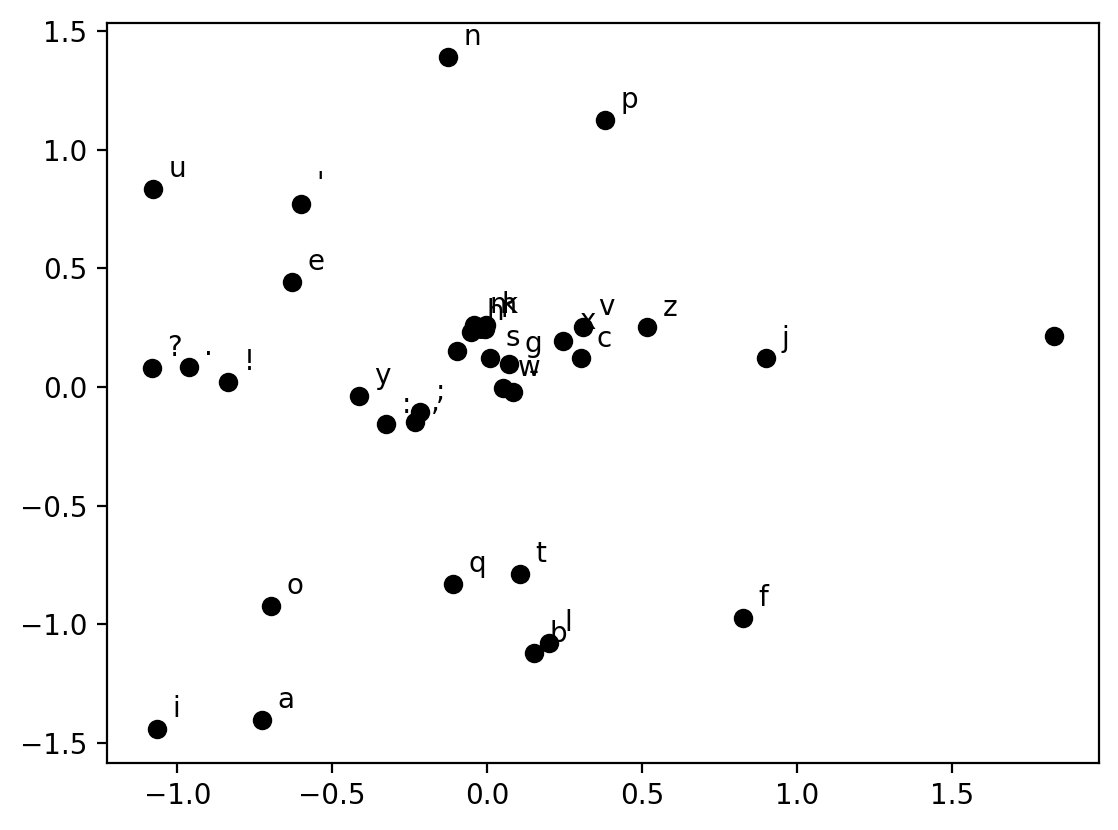

In [79]:
# Visualize the embedding

plot_emb(model.emb, itos)

In [108]:
# Generate names from trained model

for i in range(10):
    print(generate_name(model, itos, stoi, block_size))

first cits
cominius: 
all: than 
menenius: 
ay, an hay
first citi
second cit
marcius!
brutus: pe
first citi


Tuning knobs

1. Embedding size
2. MLP
3. Context length